## **Blood Pressure Prediction**

This notebook aims to predict blood pressure using bioimpedance measurements from graphene electronic tattoos.

For more detail and access to the data read this [article](https://physicsworld.com/a/graphene-tattoo-provides-cuffless-blood-pressure-monitoring/).

### **1. Data Exploration and Preprocessing**

### **1.1 Creating a combined dataset from the CSVs**

The goal of this section is to combine all of the CSVs into one pandas dataframe with the following schema:

***Subject, SetupType, Setup Trial, Time, Bioz, FinapresBP, FinapresPPG, PPG***

In [23]:
import pandas as pd
import os 
import glob
import seaborn as sns
import matplotlib.pyplot as plt

>##### **Lets start by reading the data related to one patient and setup.**

In [24]:
# The path to the setup results
path = "../../data/continuous-cuffless-monitoring-of-arterial-blood-pressure-via-graphene-bioimpedance-tattoos-1.0.0/subject1_day1/setup01_baseline"

csv_files = glob.glob(os.path.join(path, "*.csv")) 

# A list to collect DataFrames
dfs = []

# Loop over the list of csv files 
for f in csv_files: 

    # To avoid issues caused by mixing Windows and Linux paths replace \\ with /
    f = f.replace("\\", "/")

    # Extract the trial, setup and subject info from the file path
    trial_string = f.split("/")[-1]
    setup_string = f.split("/")[-2]
    subject_string = f.split("/")[-3]

    # Convert the strings into key ids for the trial, setup and subject
    trial = trial_string.split('_')[1]
    setup_type = setup_string.split('_')[1]  # Include the type of experiment done

    # Read the csv file and add the ids used to identify the experiment
    next_df = pd.read_csv(f)
    next_df['Subject'] = subject_string
    next_df['SetupType'] = setup_type
    next_df['Setup'] = setup_string
    next_df['Trial'] = trial  # Should be shared across files from the same trial

    dfs.append(next_df)

# Concatenate the dataframes into one
df = pd.concat(dfs, ignore_index=True)

df

,time,BioZ1,BioZ2,BioZ3,BioZ4,Subject,SetupType,Setup,Trial,FinapresBP,FinapresPPG,PPG
0,1.000021,45.11402,18.60437,20.92109,6.67912,subject1_day1,baseline,setup01_baseline,trial01,NaN,NaN,NaN
1,1.000821,45.19330,18.60317,20.84464,6.61070,subject1_day1,baseline,setup01_baseline,trial01,NaN,NaN,NaN
2,1.001621,45.27085,18.60096,20.76674,6.54201,subject1_day1,baseline,setup01_baseline,trial01,NaN,NaN,NaN
3,1.002421,45.34667,18.59775,20.68740,6.47308,subject1_day1,baseline,setup01_baseline,trial01,NaN,NaN,NaN
4,1.003221,45.42077,18.59353,20.60664,6.40395,subject1_day1,baseline,setup01_baseline,trial01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
479524,87.596021,NaN,NaN,NaN,NaN,subject1_day1,baseline,setup01_baseline,trial02,NaN,NaN,-0.13551
479525,87.596821,NaN,NaN,NaN,NaN,subject1_day1,baseline,setup01_baseline,trial02,NaN,NaN,-0.14933
479526,87.597621,NaN,NaN,NaN,NaN,subject1_day1,baseline,setup01_baseline,trial02,NaN,NaN,-0.16312
479527,87.598421,NaN,NaN,NaN,NaN,subject1_day1,baseline,setup01_baseline,trial02,NaN,NaN,-0.17685


Unfortunately, values from the same experiment at the same time are on different rows.

To resolve this Group By the id columns and aggregate.

Now each row should represent a metric at a specific time, providied the metric was gathered at that interval.

In [25]:
df = df.groupby(['Subject', 'SetupType', 'Setup', 'Trial', 'time']).agg('mean').reset_index()

I'll visualise one trial to get an understanding of the data.

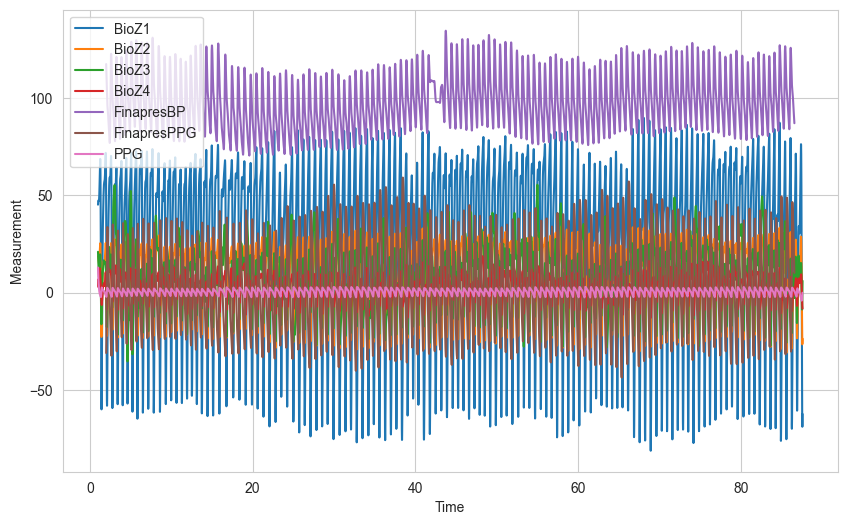

In [26]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP', 'FinapresPPG', 'PPG']

# Filter the DataFrame for Trial 1
trial1_df = df[df['Trial'] == 'trial01']

# Set the Seaborn Style
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

for column in columns_to_plot:
    sns.lineplot(data=trial1_df, x='time', y=column, label=column)

plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()

plt.show()

It's a bit of a mess. For more detail I'll limit it to a 10 second stretch

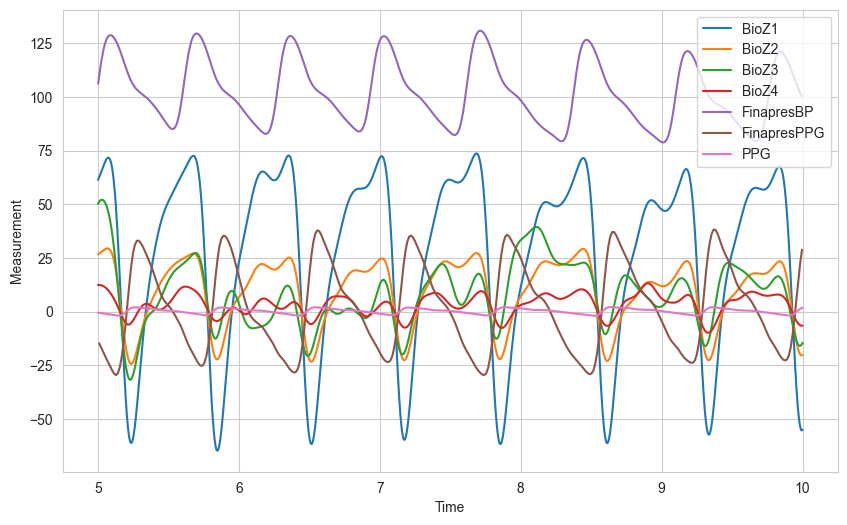

In [27]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP', 'FinapresPPG', 'PPG']

# Filter the DataFrame by time
plot_df = trial1_df[(trial1_df['time'] >= 5) & (trial1_df['time'] <= 10)]

# Create the plot
plt.figure(figsize=(10, 6))

for column in columns_to_plot:
    sns.lineplot(data=plot_df, x='time', y=column, label=column)

plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()
plt.show()

Lets plot each Measurement directly against Blood Pressure.

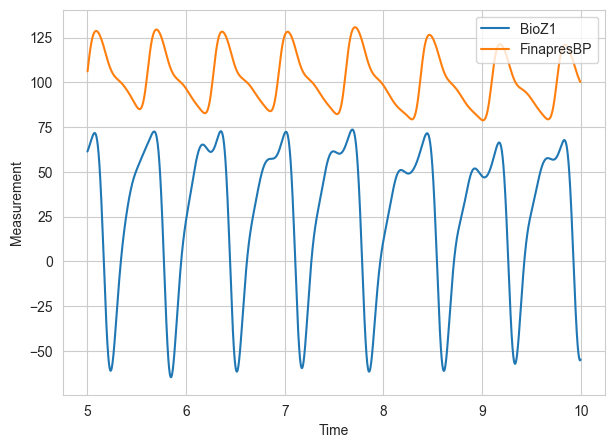

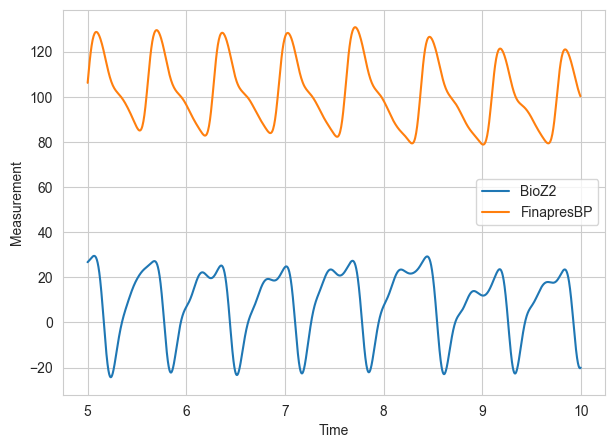

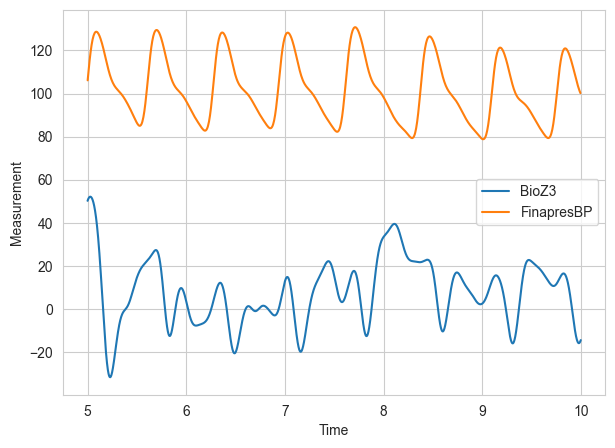

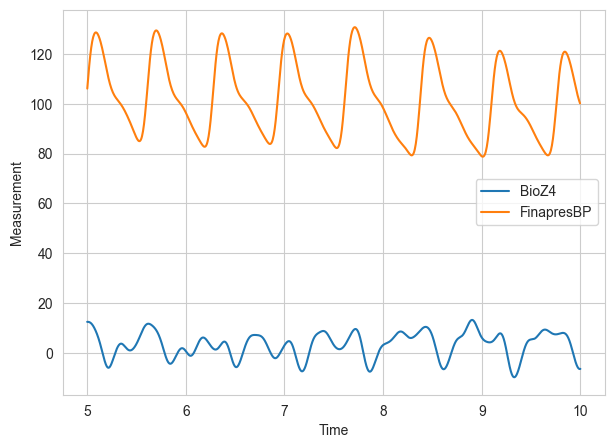

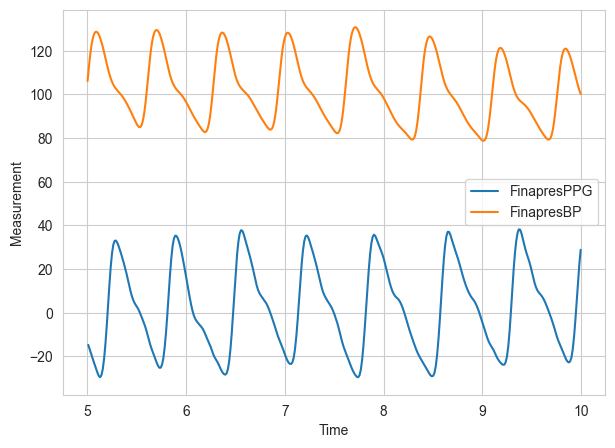

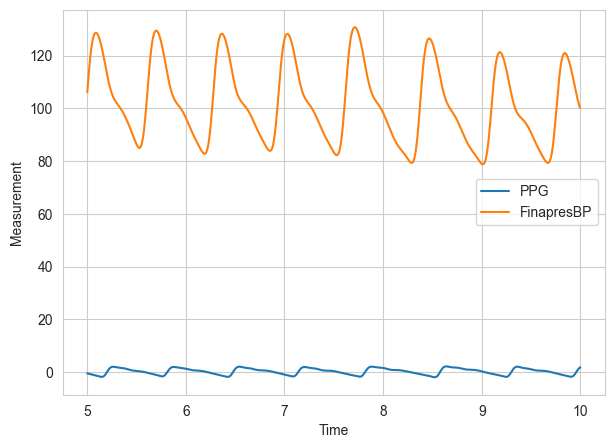

In [28]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresPPG', 'PPG']

# Filter the DataFrame for Trial 1
trial1_df = df[df['Trial'] == 'trial01']
plot_df = trial1_df[(trial1_df['time'] >= 5) & (trial1_df['time'] <= 10)]

for column in columns_to_plot:
    plt.figure(figsize=(7, 5))
    sns.lineplot(data=plot_df, x='time', y=column, label=column)
    sns.lineplot(data=plot_df, x='time', y='FinapresBP', label='FinapresBP')
    plt.xlabel('Time')
    plt.ylabel('Measurement')
    plt.legend()
    plt.show()

>##### **Now I'll repeat this with all of the CSVs**

In [29]:
# Create a list for the dataframes again
dfs = []

# Set this to the to the root folder of the data
path = "../../data/continuous-cuffless-monitoring-of-arterial-blood-pressure-via-graphene-bioimpedance-tattoos-1.0.0"

# Get all of the subject folders
subject_folders = glob.glob(os.path.join(path, "*" + os.sep))  # os.sep ensures that only directories are matched

# Iterate over each subject folder abd examine each setup folder
for subject_folder in subject_folders:
    setup_folders = glob.glob(os.path.join(subject_folder, "*" + os.sep))

    # Iterate over each setup folder adding the CSVs within
    for setup_folder in setup_folders:
        csv_files = glob.glob(os.path.join(setup_folder, "*.csv")) 

        # Loop over the list of csv files 
        for f in csv_files: 

            # To avoid issues caused by mixing Windows and Linux paths replace \\ with /
            f = f.replace("\\", "/")

            # Extract the trial, setup and subject info from the file path
            trial_string = f.split("/")[-1]
            setup_string = f.split("/")[-2]
            subject_string = f.split("/")[-3]

            # Convert the strings into key ids for the trial, setup and subject
            trial = trial_string.split('_')[1]
            setup_type = setup_string.split('_')[1]  # Include the type of experiment done

            # Read the csv file and add the ids used to identify the experiment
            next_df = pd.read_csv(f)
            next_df['Subject'] = subject_string
            next_df['SetupType'] = setup_type
            next_df['Setup'] = setup_string
            next_df['Trial'] = trial  # Should be shared across files from the same trial

            dfs.append(next_df)

df = pd.concat(dfs, ignore_index=True)

In [30]:
df

,time,BioZ1,BioZ2,BioZ3,BioZ4,Subject,SetupType,Setup,Trial,FinapresBP,FinapresPPG,PPG
0,1.000021,45.11402,18.60437,20.92109,6.67912,subject1_day1,baseline,setup01_baseline,trial01,NaN,NaN,NaN
1,1.000821,45.19330,18.60317,20.84464,6.61070,subject1_day1,baseline,setup01_baseline,trial01,NaN,NaN,NaN
2,1.001621,45.27085,18.60096,20.76674,6.54201,subject1_day1,baseline,setup01_baseline,trial01,NaN,NaN,NaN
3,1.002421,45.34667,18.59775,20.68740,6.47308,subject1_day1,baseline,setup01_baseline,trial01,NaN,NaN,NaN
4,1.003221,45.42077,18.59353,20.60664,6.40395,subject1_day1,baseline,setup01_baseline,trial01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
63191121,189.996021,NaN,NaN,NaN,NaN,subject7_day1,cycling,setup01_cycling,trial3,NaN,NaN,-1.55078
63191122,189.996821,NaN,NaN,NaN,NaN,subject7_day1,cycling,setup01_cycling,trial3,NaN,NaN,-1.72011
63191123,189.997621,NaN,NaN,NaN,NaN,subject7_day1,cycling,setup01_cycling,trial3,NaN,NaN,-1.88935
63191124,189.998421,NaN,NaN,NaN,NaN,subject7_day1,cycling,setup01_cycling,trial3,NaN,NaN,-2.05850


Get each metric on 1 row again.

In [31]:
df = df.groupby(['Subject', 'SetupType', 'Setup', 'Trial', 'time']).agg('mean').reset_index()

An overview of the dataset.

In [32]:
display(df)
df.info()
df.describe()

,Subject,SetupType,Setup,Trial,time,BioZ1,BioZ2,BioZ3,BioZ4,FinapresBP,FinapresPPG,PPG
0,subject1_day1,baseline,setup01_baseline,trial01,1.000021,45.11402,18.60437,20.92109,6.67912,NaN,NaN,12.85023
1,subject1_day1,baseline,setup01_baseline,trial01,1.000821,45.19330,18.60317,20.84464,6.61070,NaN,NaN,12.72152
2,subject1_day1,baseline,setup01_baseline,trial01,1.001621,45.27085,18.60096,20.76674,6.54201,NaN,NaN,12.59401
3,subject1_day1,baseline,setup01_baseline,trial01,1.002421,45.34667,18.59775,20.68740,6.47308,NaN,NaN,12.46770
4,subject1_day1,baseline,setup01_baseline,trial01,1.003221,45.42077,18.59353,20.60664,6.40395,NaN,NaN,12.34258
...,...,...,...,...,...,...,...,...,...,...,...,...
34886301,subject7_day1,cycling,setup01_cycling,trial3,189.996021,35.49052,1.36802,60.85998,NaN,NaN,NaN,-1.55078
34886302,subject7_day1,cycling,setup01_cycling,trial3,189.996821,35.54783,1.39600,60.78624,NaN,NaN,NaN,-1.72011
34886303,subject7_day1,cycling,setup01_cycling,trial3,189.997621,35.60521,1.42414,60.71107,NaN,NaN,NaN,-1.88935
34886304,subject7_day1,cycling,setup01_cycling,trial3,189.998421,35.66269,1.45247,60.63445,NaN,NaN,NaN,-2.05850


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886306 entries, 0 to 34886305
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Subject      object 
 1   SetupType    object 
 2   Setup        object 
 3   Trial        object 
 4   time         float64
 5   BioZ1        float64
 6   BioZ2        float64
 7   BioZ3        float64
 8   BioZ4        float64
 9   FinapresBP   float64
 10  FinapresPPG  float64
 11  PPG          float64
dtypes: float64(8), object(4)
memory usage: 3.1+ GB


,time,BioZ1,BioZ2,BioZ3,BioZ4,FinapresBP,FinapresPPG,PPG
count,3.488631e+07,2.852900e+07,2.852900e+07,2.852900e+07,2.782025e+07,4.460472e+06,1.672654e+06,2.852900e+07
mean,4.591208e+01,4.231964e+01,-6.467284e+00,1.099465e+02,-1.913159e+01,1.043936e+02,6.207411e+00,5.822469e-01
std,2.781938e+01,9.257526e+02,3.079119e+02,4.478090e+03,2.783277e+02,2.236611e+01,3.129455e+01,5.595687e+00
min,1.000021e+00,-2.474235e+04,-5.351118e+03,-3.109017e+05,-5.840000e+03,9.727800e+00,-1.316752e+02,-6.274378e+01
25%,2.311340e+01,-1.243984e+01,-6.119770e+00,-6.232210e+00,-4.513650e+00,8.838371e+01,-1.818167e+01,-8.453400e-01
50%,4.504882e+01,1.616495e+01,4.526805e+00,3.796680e+00,1.808920e+00,1.030136e+02,5.774330e+00,2.760000e-01
75%,6.698409e+01,4.346836e+01,1.515394e+01,1.376887e+01,7.532520e+00,1.188909e+02,2.898137e+01,1.428820e+00
max,1.899993e+02,1.670679e+04,3.823919e+03,6.540227e+05,3.697884e+03,2.216132e+02,1.701266e+02,7.179808e+01


We should double check that the data aligns with the folders and the descriptions in the README. 

In [45]:
print(df['Subject'].unique(), "\n")
print(df['SetupType'].unique(), "\n")

['subject1_day1' 'subject1_day4' 'subject2_day1' 'subject3_day1'
 'subject4_day1' 'subject5_day1' 'subject6_day1' 'subject7_day1'] 

['baseline' 'hgcp' 'valsalva' 'rest' 'cycling'] 



Show the correlation matrix of each of the variables.

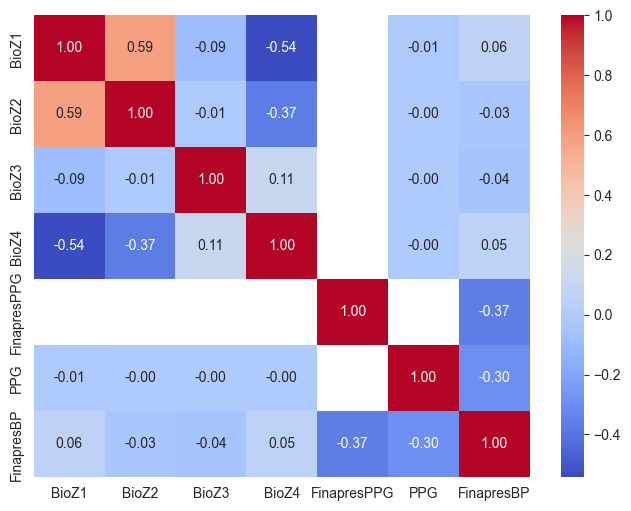

In [33]:
correlation_matrix = df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresPPG', 'PPG', 'FinapresBP']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()